In [ ]:
!pip install git+https://github.com/tensorflow/examples.git#egg=tensorflow-examples[model_maker]

In [2]:
import numpy as np
import os
import time

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.configs import QuantizationConfig
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec
from PIL import Image

import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0-dev20200719


In [ ]:
# Unzipping files
!unzip ./dataset.zip -d ./dataset
!rm -r ./dataset.zip

In [4]:
# Load data
data = ImageClassifierDataLoader.from_folder(os.path.join(os.getcwd(), 'dataset'))
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

INFO:tensorflow:Load image with size: 150, num_label: 3, labels: nishikino_maki, sakurauchi_riko, takimoto_hifumi.


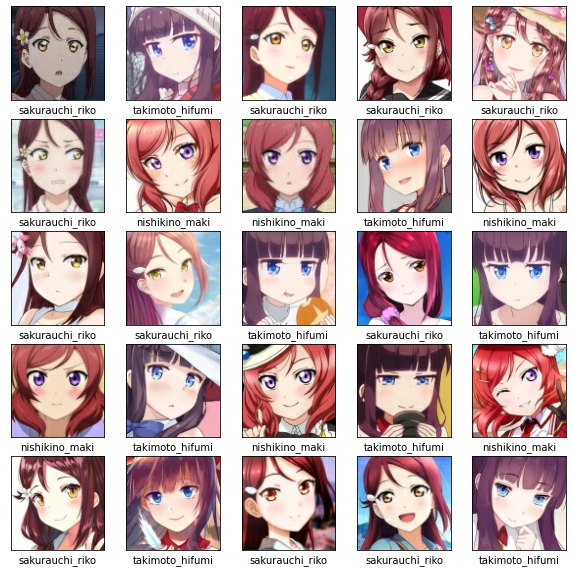

In [5]:
# Data Exploration
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.dataset.take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [6]:
# Customize the TensorFlow model
inception_v3_spec = ImageModelSpec(uri = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4')

model = image_classifier.create(train_data,
                                validation_data = validation_data, 
                                model_spec = inception_v3_spec, 
                                batch_size = 15,
                                epochs = 10)
model.summary()

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 13s 2s/step - loss: 1.0386 - accuracy: 0.5500 - val_loss: 1.0568 - val_accuracy: 0.6000
Epoch 2/10
8/8 [==============================] - 13s 2s/step - loss: 0.6559 - accuracy: 0.8500 - val_loss: 0.5335 - val_accuracy: 0.9333
Epoch 3/10
8/8 [==============================] 

In [7]:
# Model Evaluation
loss, accuracy = model.evaluate(test_data)
model.export(export_dir = os.getcwd())

1/1 [==============================] - 0s 1ms/step - loss: 0.3962 - accuracy: 1.0000
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmp3kxm5yy8/assets


INFO:tensorflow:Assets written to: /tmp/tmp3kxm5yy8/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp58_9i1zi/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmp58_9i1zi/labels.txt.


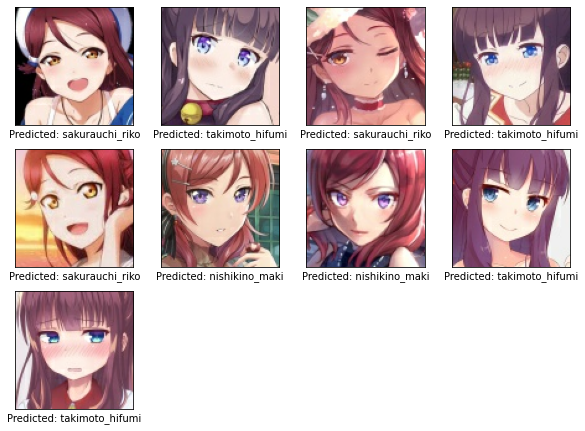

In [8]:
# A helper function that returns 'red'/'black' depending on if its two input parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 9 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test" dataset,
# Let's simply highlight it in red color.
plt.figure(figsize=(10, 10))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(9)):
  ax = plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [9]:
def recreate_labels():
  # 1) We use this in order to ignore any hidden files that might be here.
  # 'Datasets' is the name of the folder where we store our training data. The 'listdir' is used to fetch all the folder names.
  labels = [folder for folder in os.listdir('dataset') if not folder.startswith('.')]
  
  # 2) Then, we output the contents of each folder name to a file.
  with open('labels.txt', 'w') as file:
    for label in labels:
      file.write(label)
      file.write('\n')

recreate_labels()  

In [10]:
# Test our images with Python script from TensorFlow's example.
!wget https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/lite/examples/python/label_image.py

--2020-07-20 09:25:45--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/lite/examples/python/label_image.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3106 (3.0K) [text/plain]
Saving to: ‘label_image.py’

label_image.py      100%[===================>]   3.03K  --.-KB/s    in 0s      

2020-07-20 09:25:45 (45.9 MB/s) - ‘label_image.py’ saved [3106/3106]



In [11]:
# Test it automatically!
!python3 label_image.py \
  --model_file ./model.tflite \
  --label_file ./labels.txt \
  --image ./50.jpg

2020-07-20 09:26:24.188475: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
0.705003: nishikino_maki
0.235544: sakurauchi_riko
0.059453: takimoto_hifumi
time: 341.881ms
